In [123]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import socket
import os as os
import sys as sys
import multiprocessing as mp
from scipy import stats

socket_name = socket.gethostname()
print(socket_name)

if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine

elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster

else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

sys.path.append("./PackagesSupport/")  # Since now we are in the Root Directory
from pp_individual_roh_csvs import post_process_roh_df, merge_called_blocks, individual_roh_statistic  # Import PP Functions
#from createMosaicsMulti import Mosaic_1000G_Multi  # Import the object that can create the Multiruns

### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

midway2-0402.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


## Helper Functions

In [2]:
def merge_to_one_df(df1, df2, on="iid", min_snps=500000, max_age=1e6, only_inc_alt=True):
    """Merge Two Dataframes to one"""
    
    df_merge = pd.merge(df1, df2, on="iid")
    print(f"Merged to {len(df_merge)} Inds. (from {len(df1)} and {len(df2)}) resp.")
    
    ### Filter to High Coverage Individuals
    df_merge = df_merge[df_merge["n_cov_snp_x"] > min_snps]
    df_merge = df_merge[df_merge["age_x"] < max_age]
    if only_inc_alt:
        df_merge = df_merge[df_merge["include_alt_x"] > 0]
    print(f"Further filtered to {len(df_merge)} Individuals")
    return df_merge

def plot_correlation_roh(df_merge, xlim=[0,380], ylim=[0,380], savepath="", 
                         col1="sum_roh>4_y", col2="sum_roh>4_x", c_col="age_x", 
                         barlabel="Age [y BP]", figsize=(8,8), pad=20,
                         c_line="gray", lw=0.2, s=20, fs=14, fs_t=8, padax=4, 
                         vrange=[0.3,30], cmap="viridis", cb_pad=0.0,
                         cb_coords=[0.27, 0.8, 0.5, 0.05], pad_t1=4, 
                         tickwidth=2, ticklength=6, roh_bin=">4"):
    """Plot correlation between ROH inferred on pseudo-haploid
    and on Readcount data. Print Pearson product-moment correlation coefficient"""
    r = np.corrcoef(df_merge[col1], df_merge[col2])[0,1]

    fig=plt.figure(figsize=figsize)
    ax=plt.gca()
    sc=ax.scatter(df_merge[col1], df_merge[col2], c=df_merge[c_col],
                  s=s, ec="k", lw=lw, zorder=1, norm=colors.Normalize(vmin=vrange[0], vmax=vrange[1]),
                  cmap=cmap) #LogNorm
    ax.plot(xlim, xlim, c=c_line, alpha=0.8, zorder=0)
    ax.set_xlabel("Sum Full Readcount Data (cM)", fontsize=fs, labelpad=padax)
    ax.set_ylabel("Sum Pseudohaploid Data only (cM)", fontsize=fs, labelpad=padax)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.tick_params(labelsize=fs_t, width=tickwidth, length=ticklength, pad=pad_t1)
    text1=f"$r={r:.3f}$"
    text2=f"Inferred Sum ROH{roh_bin}cm \n for {len(df_merge)} individuals \n>300k SNPs covered"
    ax.text(0.55, 0.02, text1, transform=ax.transAxes, fontsize=fs)
    ax.text(0.04, 0.83, text2, transform=ax.transAxes, fontsize=fs)
    
    # Do Colorbar Shennenigans
    cax = fig.add_axes(cb_coords)
    #fig.colorbar(im, cax=cax, orientation='horizontal')
    cb = fig.colorbar(sc, cax=cax, orientation='vertical', extend="max", pad=cb_pad)
    cb.ax.set_ylabel(barlabel, rotation=270, fontsize=fs, labelpad=pad)
    cb.ax.tick_params(labelsize=fs_t, direction="in")
    cb.ax.yaxis.set_ticks_position('left')
    cb.ax.tick_params(width=tickwidth, length=ticklength)
    
    if len(savepath)>0:
        plt.savefig(savepath) # bbox_inches = 'tight', pad_inches = 0
        print(f"Saved to {savepath}")
    plt.show()

In [4]:
df_marcus_rc = pd.read_csv("./Empirical/1240k/MarcusAncs/combined_roh05.csv", "\t")
df_marcus_ph = pd.read_csv("./Empirical/1240k/MarcusAncsPH/combined_roh05.csv", "\t")
df_reich_ph = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", '\t')  # Load ES Data
df_all = pd.read_csv("./Empirical/roh_all_inds.csv", '\t')  # Load final filtered Dataframe (duplicate Individuals filtered)

### Sum ROH longer than 4 cM

Merged to 511 Inds. (from 3233 and 557) resp.
Further filtered to 511 Individuals
Saved to ./figures/manuscript/fig1/fig1b_ph_rc_g4.pdf


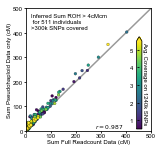

In [32]:
df1, df2 = df_all, df_marcus_rc   # Choice what to compare
df_merge = merge_to_one_df(df1, df2, min_snps=300000) # max_age=7000
df_merge = df_merge.sort_values(by="mean_cov_x")

plot_correlation_roh(df_merge, xlim=[0,500], ylim=[0,500], c_col="mean_cov_x",padax=0.5,
                     lw=0.2, s=8, figsize=(2.25, 2.25), fs=6, fs_t=6, pad=5, cb_pad=-0.2,
                     barlabel="Avg. Coverage on 1240k SNPs", vrange=[0.5,5.5], roh_bin=" > 4cM",
                     cb_coords = [0.81, 0.135, 0.033, 0.57], tickwidth=0.8, pad_t1=0.7,
                     ticklength=2, savepath = "./figures/manuscript/fig1/fig1b_ph_rc_g4.pdf")

### Sum ROH longer than 8 cM

In [ ]:
df1, df2 = df_all, df_marcus_rc   # Choice what to compare
df_merge = merge_to_one_df(df1, df2, min_snps=300000) # max_age=7000
df_merge = df_merge.sort_values(by="mean_cov_x")
plot_correlation_roh(df_merge, xlim=[0,450], ylim=[0,450], c_col="mean_cov_x",padax=0.5,
                     lw=0.2, s=10, figsize=(2.25, 2.25), fs=6, fs_t=6, pad=6, cb_pad=-0.2,
                     barlabel="Avg. Coverage on 1240k SNPs", vrange=[0.5,5.5],
                     cb_coords = [0.81, 0.135, 0.033, 0.57], tickwidth=0.8, roh_bin=" > 8",
                     ticklength=2, savepath = "./figures/manuscript/fig1/fig1b_ph_rc_g8.pdf",
                     col1="sum_roh>8_y", col2="sum_roh>8_x", pad_t1=0.7)

### Test for Blocks 4-8 cM

In [17]:
df_t = df_merge.copy()
df_t["sum_roh_4-8_x"] = df_t["sum_roh>4_x"] - df_t["sum_roh>8_x"] 
df_t["sum_roh_4-8_y"] = df_t["sum_roh>4_y"] - df_t["sum_roh>8_y"] 

Saved to ./figures/manuscript/fig1/fig1b_ph_rc_4-8.pdf


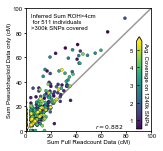

In [18]:
df_t = df_t.sort_values(by="mean_cov_x")
plot_correlation_roh(df_t, xlim=[0,100], ylim=[0,100], c_col="mean_cov_x",padax=0.5,
                     lw=0.2, s=10, figsize=(2.25, 2.25), fs=6, fs_t=6, pad=6, cb_pad=-0.2,
                     barlabel="Avg. Coverage on 1240k SNPs", vrange=[0.5,5.5],
                     cb_coords = [0.81, 0.135, 0.033, 0.57], tickwidth=0.8,
                     ticklength=2, savepath = "./figures/manuscript/fig1/fig1b_ph_rc_4-8.pdf",
                     col1="sum_roh_4-8_y", col2="sum_roh_4-8_x", pad_t1=0.7)

### For Blocks 8-12 cM

In [20]:
df_t = df_merge.copy()
df_t["sum_roh_8-12_x"] = df_t["sum_roh>8_x"] - df_t["sum_roh>12_x"] 
df_t["sum_roh_8-12_y"] = df_t["sum_roh>8_y"] - df_t["sum_roh>12_y"] 

Saved to ./figures/manuscript/fig1/fig1b_ph_rc_8-12.pdf


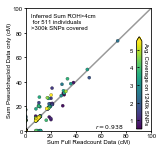

In [26]:
df_t = df_t.sort_values(by="mean_cov_x")
plot_correlation_roh(df_t, xlim=[0,100], ylim=[0,100], c_col="mean_cov_x",padax=0.5,
                     lw=0.2, s=10, figsize=(2.25, 2.25), fs=6, fs_t=6, pad=6, cb_pad=-0.2,
                     barlabel="Avg. Coverage on 1240k SNPs", vrange=[0.5,5.5],
                     cb_coords = [0.81, 0.135, 0.033, 0.57], tickwidth=0.8,
                     ticklength=2, savepath = "./figures/manuscript/fig1/fig1b_ph_rc_8-12.pdf",
                     col1="sum_roh_8-12_y", col2="sum_roh_8-12_x", pad_t1=0.7)

# Compare Pseudohaploid Marcus with Readcounts Marcus

### Sum ROH>4cM

Merged to 497 Inds. (from 1098 and 557) resp.
Further filtered to 471 Individuals
Saved to ./figures/manuscript/fig1/fig1b_ph_rc_marcus_g4.pdf


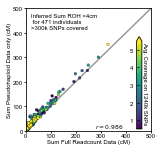

In [5]:
df1, df2 = df_reich_ph, df_marcus_rc   # Choice what to compare
df_merge = merge_to_one_df(df1, df2, min_snps=300000) # max_age=7000
df_merge = df_merge.sort_values(by="mean_cov_x")

plot_correlation_roh(df_merge, xlim=[0,500], ylim=[0,500], c_col="mean_cov_x",padax=0.5,
                     lw=0.2, s=8, figsize=(2.25, 2.25), fs=6, fs_t=6, pad=5, cb_pad=-0.2,
                     barlabel="Avg. Coverage on 1240k SNPs", vrange=[0.5,5.5], roh_bin=" >4",
                     cb_coords = [0.81, 0.135, 0.033, 0.57], tickwidth=0.8, pad_t1=0.7,
                     ticklength=2, savepath = "./figures/manuscript/fig1/fig1b_ph_rc_marcus_g4.pdf")

### Sum ROH>8cM

In [11]:
df1, df2 = df_marcus_ph, df_marcus_rc   # Choice what to compare
df_merge = merge_to_one_df(df1, df2, min_snps=300000) # max_age=7000
df_merge = df_merge.sort_values(by="mean_cov_x")

plot_correlation_roh(df_merge, xlim=[0,450], ylim=[0,450], c_col="mean_cov_x",padax=0.5,
                     lw=0.2, s=10, figsize=(2.25, 2.25), fs=6, fs_t=6, pad=6, cb_pad=-0.2,
                     barlabel="Avg. Coverage on 1240k SNPs", vrange=[0.5,5.5],
                     cb_coords = [0.81, 0.135, 0.033, 0.57], tickwidth=0.8, roh_bin=" >8",
                     ticklength=2, savepath = "./figures/manuscript/fig1/fig1b_ph_rc_marcus_g8.pdf",
                     col1="sum_roh>8_y", col2="sum_roh>8_x", pad_t1=0.7)

NameError: name 'df_marcus_ph' is not defined

### 4-8 cM

In [65]:
df1, df2 = df_marcus_ph, df_marcus_rc   # Choice what to compare
df_merge = merge_to_one_df(df1, df2, min_snps=300000) # max_age=7000

df_t = df_merge.copy()
df_t["sum_roh_4-8_x"] = df_t["sum_roh>4_x"] - df_t["sum_roh>8_x"] 
df_t["sum_roh_4-8_y"] = df_t["sum_roh>4_y"] - df_t["sum_roh>8_y"] 

Merged to 517 Inds. (from 517 and 557) resp.
Further filtered to 517 Individuals


Saved to ./figures/manuscript/fig1/fig1b_ph_rc_4-8.pdf


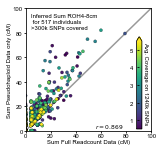

In [66]:
df_t = df_t.sort_values(by="mean_cov_x")
plot_correlation_roh(df_t, xlim=[0,100], ylim=[0,100], c_col="mean_cov_x",padax=0.5,
                     lw=0.2, s=10, figsize=(2.25, 2.25), fs=6, fs_t=6, pad=6, cb_pad=-0.2,
                     barlabel="Avg. Coverage on 1240k SNPs", vrange=[0.5,5.5],
                     cb_coords = [0.81, 0.135, 0.033, 0.57], tickwidth=0.8, roh_bin="4-8",
                     ticklength=2, savepath = "./figures/manuscript/fig1/fig1b_ph_rc_4-8.pdf",
                     col1="sum_roh_4-8_y", col2="sum_roh_4-8_x", pad_t1=0.7)

### Only for high coverage Individuals

In [23]:
c=5

df1, df2 = df_marcus_ph, df_marcus_rc   # Choice what to compare
df_merge = merge_to_one_df(df1, df2, min_snps=300000) # max_age=7000

df_t = df_merge.copy()
df_t["sum_roh_4-8_x"] = df_t["sum_roh>4_x"] - df_t["sum_roh>8_x"] 
df_t["sum_roh_4-8_y"] = df_t["sum_roh>4_y"] - df_t["sum_roh>8_y"] 

df_t = df_t[df_t["mean_cov_y"]>c]
print(f"{len(df_t)} Indivdiuals Coverage > {c} x")

Merged to 517 Inds. (from 517 and 557) resp.
Further filtered to 517 Individuals
34 Indivdiuals Coverage > 5 x


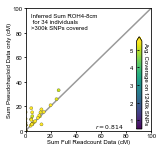

In [24]:
df_t = df_t.sort_values(by="mean_cov_x")
plot_correlation_roh(df_t, xlim=[0,100], ylim=[0,100], c_col="mean_cov_x",padax=0.5,
                     lw=0.2, s=10, figsize=(2.25, 2.25), fs=6, fs_t=6, pad=6, cb_pad=-0.2,
                     barlabel="Avg. Coverage on 1240k SNPs", vrange=[0.5,5.5],
                     cb_coords = [0.81, 0.135, 0.033, 0.57], tickwidth=0.8, roh_bin="4-8",
                     ticklength=2, savepath = "",
                     col1="sum_roh_4-8_y", col2="sum_roh_4-8_x", pad_t1=0.7)

### Quantify Bias

In [84]:
df1, df2 = df_marcus_ph, df_marcus_rc   # Choice what to compare
df_merge = merge_to_one_df(df1, df2, min_snps=300000) # max_age=7000
c=0

df_t = df_merge.copy()
df_t = df_t[df_t["mean_cov_y"]>c]

print(f"{len(df_t)} Indivdiuals Coverage > {c} x")

x = df_t["sum_roh>4_x"] - df_t["sum_roh>8_x"] 
y = df_t["sum_roh>4_y"] - df_t["sum_roh>8_y"] 
c = df_t["mean_cov_y"]
age = df_t["age_x"]
df_t["sum_roh_4-8_x"] = x
df_t["sum_roh_4-8_y"] = y

print(f"Mean Bias: {np.mean(x-y):.4f} cM")
print(f"Sum 0 in both: {np.sum((x==0) & (y==0))}")

Merged to 517 Inds. (from 517 and 557) resp.
Further filtered to 517 Individuals
517 Indivdiuals Coverage > 0 x
Mean Bias: 5.2697 cM
Sum 0 in both: 100


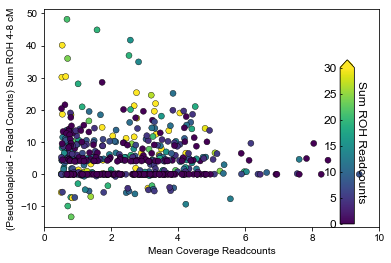

In [111]:
vrange=[0,30]
cmap="viridis"
cb_pad=0.0
barlabel="Sum ROH Readcounts"
fs, fs_t=12,12
pad=12
cb_coords = [0.81,
             0.135, 0.033, 0.57]
tickwidth=0.8
pad_t1=0.7
ticklength=2
  
fig = plt.figure()
sc = plt.scatter(c, x-y, c=y, ec="k", norm=colors.Normalize(vmin=vrange[0], vmax=vrange[1]),
                  cmap=cmap, lw=0.4)
plt.xlabel("Mean Coverage Readcounts")
plt.ylabel("(Pseudohaploid - Read Counts) Sum ROH 4-8 cM")
plt.xlim([0,10])

# Do Colorbar Shennenigans
cax = fig.add_axes(cb_coords)
#fig.colorbar(im, cax=cax, orientation='horizontal')
cb = fig.colorbar(sc, cax=cax, orientation='vertical', extend="max", pad=cb_pad)
cb.ax.set_ylabel(barlabel, rotation=270, fontsize=fs, labelpad=pad)
cb.ax.tick_params(labelsize=fs_t, direction="in")
cb.ax.yaxis.set_ticks_position('left')
cb.ax.tick_params(width=tickwidth, length=ticklength)

plt.show()

In [120]:
np.corrcoef(x-y, c)

array([[ 1.        , -0.07038796],
       [-0.07038796,  1.        ]])

In [119]:
np.corrcoef(x-y, age)

array([[1.        , 0.37572457],
       [0.37572457, 1.        ]])

In [121]:
np.corrcoef(x-y, y)

array([[1.       , 0.2866809],
       [0.2866809, 1.       ]])

In [122]:
np.corrcoef(y, age)

array([[1.        , 0.31615517],
       [0.31615517, 1.        ]])

In [117]:
np.mean(y-x)

-5.269672609284333

# Area 51

In [28]:
df_all = pd.read_csv("./Empirical/roh_all_inds.csv", '\t')

In [98]:
np.sum(df_all["age"]>0)

1292